In [12]:
import matplotlib
import dotenv
from pathlib import Path
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [13]:
def basic_text_analysis(texts, dataset_name="dataset"):
    assert isinstance(texts, list)
    assert all(isinstance(t, str) for t in texts)

    def word_count(t):
        return len(t.split())

    def sentence_count(t):
        return len(re.findall(r'[.!?]+', t))

    data = {
        "char_len": [len(t) for t in texts],
        "word_count": [word_count(t) for t in texts],
        "sentence_count": [sentence_count(t) for t in texts],
    }

    df = pd.DataFrame(data)

    summary = {
        "dataset": dataset_name,
        "num_texts": len(texts),
        "char_len_mean": df.char_len.mean(),
        "char_len_median": df.char_len.median(),
        "word_count_mean": df.word_count.mean(),
        "word_count_median": df.word_count.median(),
        "sentence_count_mean": df.sentence_count.mean(),
    }

    return df, summary

In [80]:
def plot_distributions(df, dataset_name="dataset"):
    plt.figure()
    plt.hist(df["char_len"], bins=30)
    plt.title(f"Character Length Distribution — {dataset_name}")
    plt.xlabel("Characters")
    plt.ylabel("Frequency")
    plt.savefig('char_distribution.png')
    plt.show()

    plt.figure()
    plt.hist(df["word_count"], bins=10)
    plt.title(f"Word Count Distribution — {dataset_name}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.savefig('word_distribution.png')
    plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt
from collections import Counter

def plot_vocab_overlap(ro_list, md_list, stop_words=None, min_token_len=2):
    """
    Vocabulary overlap.
    If stop_words is provided:
        - remove stop words
        - remove short tokens
    If stop_words is None or empty:
        - keep everything as-is
    """

    stop_words = set(w.lower() for w in stop_words) if stop_words else None

    def tokenize(text):
        words = re.findall(r'\w+', text.lower())

        # No filtering at all
        if stop_words is None:
            return words

        # Coupled filtering
        return [
            w for w in words
            if w not in stop_words and len(w) >= min_token_len
        ]

    ro_tokens = {w for s in ro_list for w in tokenize(s)}
    md_tokens = {w for s in md_list for w in tokenize(s)}

    shared = ro_tokens & md_tokens
    unique_ro = ro_tokens - shared
    unique_md = md_tokens - shared

    counts = [len(unique_ro), len(shared), len(unique_md)]
    labels = ['Unique RO', 'Shared', 'Unique MD']
    colors = ['#1f77b4', '#7f7f7f', '#ff7f0e']

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, counts, color=colors, alpha=0.8)

    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{int(bar.get_height())}',
            ha='center',
            va='bottom'
        )

    plt.title('Vocabulary Overlap: Romanian vs Moldovan Sources')
    plt.ylabel('Unique Word Count')
    plt.tight_layout()
    plt.savefig('vocab_overlap.png')
    plt.show()
    plt.close()


In [74]:
def plot_diverging_bars(ro_list, md_list, top_k, stopwords):
    """
    Plots top frequent words as diverging bars (Left=RO, Right=MD).
    """
    
    def get_clean_tokens(text_list):
        tokens = []
        for text in text_list:
            # Filter stopwords and short words
            tokens.extend([t for t in re.findall(r'\w+', text.lower()) if t not in stopwords and len(t) > 2])
        return tokens

    # Count Frequencies
    ro_counts = Counter(get_clean_tokens(ro_list))
    md_counts = Counter(get_clean_tokens(md_list))
    
    # Get top words from combined corpus
    combined_counts = ro_counts + md_counts
    top_words = [w for w, c in combined_counts.most_common(top_k)][::-1] # Reverse for plotting top-down
    
    # Extract values
    ro_vals = np.array([ro_counts[w] for w in top_words])
    md_vals = np.array([md_counts[w] for w in top_words])
    
    # Plot
    y_pos = np.arange(len(top_words))
    plt.figure(figsize=(10, 8))
    title = "Frequent Non-Stop Words" if stopwords else "Frequent Words"
    
    # Negative values for Left bars, Positive for Right bars
    plt.barh(y_pos, -ro_vals, align='center', color='#1f77b4', label='Romanian Freq')
    plt.barh(y_pos, md_vals, align='center', color='#ff7f0e', label='Moldovan Freq')
    
    plt.yticks(y_pos, top_words)
    plt.xlabel('Frequency Count')
    plt.title(f'Top {top_k} {title}')
    plt.legend()
    
    # Fix x-axis labels to show positive numbers on both sides
    ticks = plt.xticks()[0]
    plt.xticks(ticks, [str(abs(int(t))) for t in ticks])
    
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.savefig('diverging_bars.png')
    plt.show()
    plt.close()

In [17]:
def get_data_summary(data: list, name:str):
    df, summary = basic_text_analysis(data, dataset_name=name)
    plot_distributions(df, dataset_name=name)

In [18]:
base_dir = Path.cwd()
data_dir = base_dir / "data"
ro_dir = data_dir / "judete"
mol_dir = data_dir / "raioane"

In [19]:
json_files = list(mol_dir.rglob('*.json'))

files = []
for file in json_files:
    files.append(file)
print(len(files))

6071


In [20]:
def sentence_splitter(text: str):
    SENT_END = r'(?<=[.!?。！？])\s+'
    sentences = re.split(SENT_END, text)

    return sentences

def clean_sentences(sentences: list):
    cleaned = []

    for s in sentences:
        text = s.replace("\n", " ").replace("\r", " ")
        text = re.sub(r"\s+", " ", text).strip()

        if len(text.split()) < 3: 
            continue
        
        if len(text.split()) > 20:
            continue

        if "foto" in text.lower().split() or "art" in text.lower().split():
            continue
        
        if not text[0].isupper():
            continue

        if text:
            cleaned.append(text)

    return cleaned

In [21]:
class Data:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = list(set(self.unpack_jsons()))

    def unpack_jsons(self):
        content = []
        json_files = list(self.root_dir.rglob('*.json'))

        for path in json_files:
            try:
                with open(path, 'r', encoding='utf-8') as f:
                    data = json.load(f)["content"]
                    sentences = sentence_splitter(data)
                    clean_sents = clean_sentences(sentences)
                    content.extend(clean_sents)
                    
            except json.JSONDecodeError:
                print(f"Skipping corrupt file: {path}")

        return content
    
    def get_splits(self, split:str):
        if split == "train":
            return self.files[:int(0.8 * len(self.files))]
        else:
            return self.files[int(0.8 * len(self.files)):]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        return self.files[idx]
    
    def __add__(self, other):
        combined = Data(self.root_dir)
        combined.files = self.files + other.files
        return combined


In [22]:
# Load parallel corpus and split into RO/MD source/target lists
parallel_dir = base_dir / "parallel_corpus"
json_files = sorted(parallel_dir.glob('*.json'))
print(f"Found {len(json_files)} files in {parallel_dir}")


def load_pairs(files):
    srcs = []
    tgts = []
    for p in files:
        try:
            with open(p, 'r', encoding='utf-8') as fh:
                obj = json.load(fh)

            src = obj.get('source')
            tgt = obj.get('target')

            if not isinstance(src, str) or not isinstance(tgt, str):
                continue

            srcs.append(src)
            tgts.append(tgt)
        except Exception as e:
            print(f"Skipping {p.name}: {e}")
            continue

    return srcs, tgts

mid = 15000
ro_files = json_files[:mid]
md_files = json_files[mid:mid*2]

ro_src, ro_tgt = load_pairs(ro_files)
md_src, md_tgt = load_pairs(md_files)

print(f"Loaded: RO pairs={len(ro_src)}, MD pairs={len(md_src)}")

# Quick sanity checks (first 3 pairs)
print("RO sample:", ro_src[:3], ro_tgt[:3])
print("MD sample:", md_src[:3], md_tgt[:3])

Found 30000 files in d:\A_Facultate\Master\NMT\Project\parallel_corpus
Loaded: RO pairs=15000, MD pairs=15000
RO sample: ['La categoria „calitate” putem integra, fara dubii, inclusiv tratamentele naturiste.', 'Așadar, toate cele 24 de voturi exprimate au fost „pentru” numirea lui Lațcău în funcția de viceprimar al Timișoarei.', 'În jocul simplu doamne și la dublu mixt cat.'] ['In the "quality" category, we can undoubtedly include natural treatments as well.', 'Therefore, all 24 votes cast were "for" the appointment of Lațcău as deputy mayor of Timișoara.', 'In singles for women and mixed doubles.']
MD sample: ['Cazul a fost înregistrat în timpul verificării bagajelor pasagerilor de la cursa „Chișinău-Istanbul”.', 'Grădinița unde-și leagănă copilăria și creșterea majoritatea copiilor din orașul Sângerei a marcat cea de-a 40-a aniversare.', 'Destinul i-a fost hărăzit să vadă cu ochi de copil și războiul, și foametea, și deportările.'] ['The case was recorded during the luggage check of p

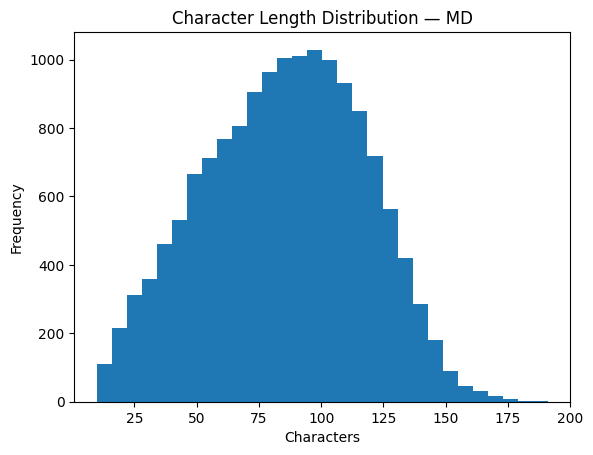

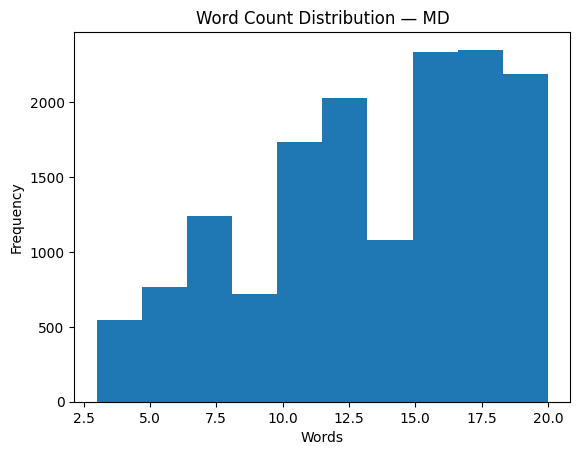

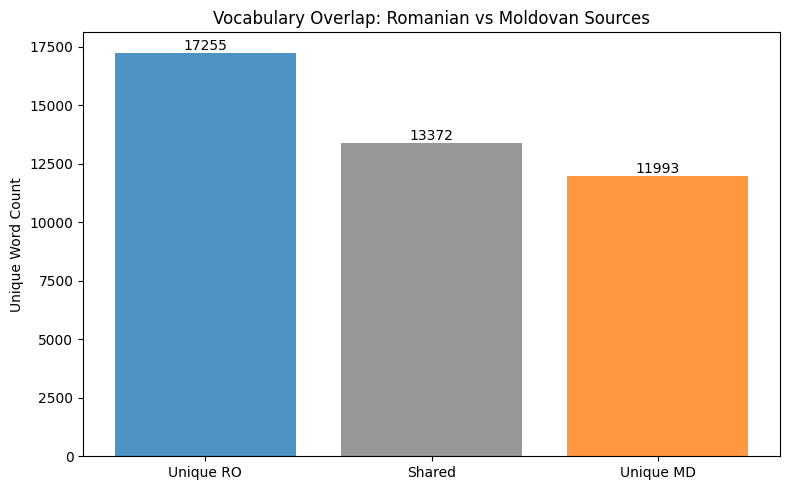

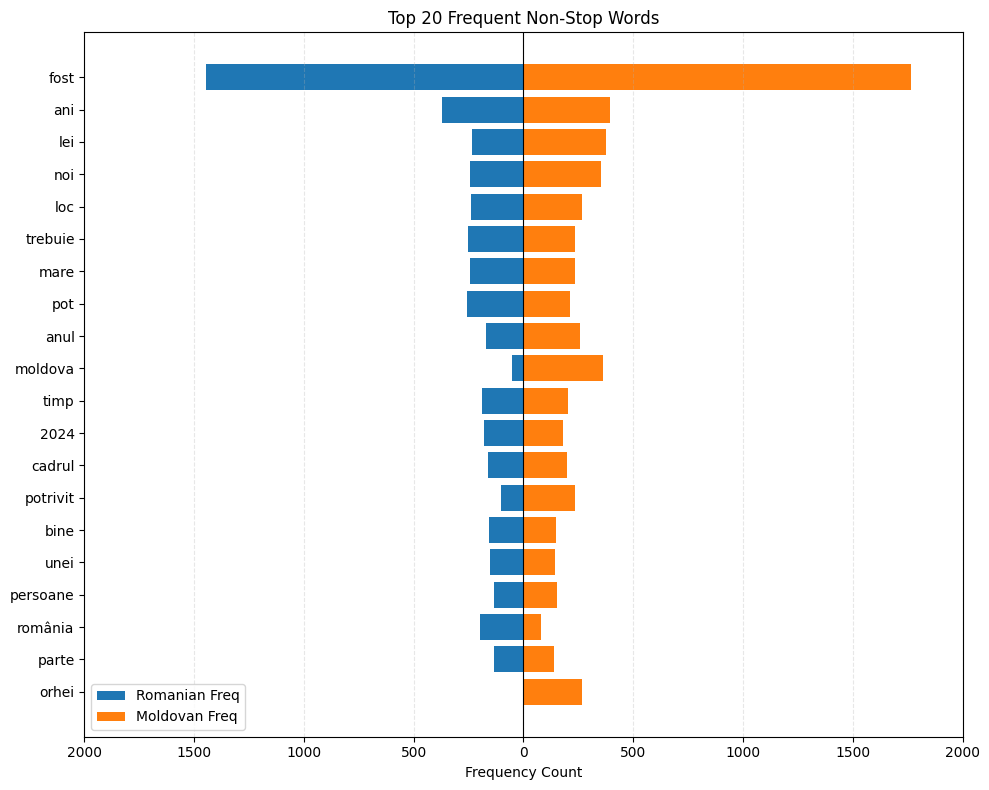

In [ ]:
get_data_summary(ro_src, "RO")
get_data_summary(md_src, "MD")
stop_words = {"acestea", "aici", "fiind", "către", "face", "fără", "de", "a", "din", "cu", "au","pentru", "să", "o", "peste", "pe", "nu", "în", "și", "la","este", "un", "care", "mai", "se", "că", "s", "am", "va", "ce","fi", "sunt", "al", "vor", "acest", "ca", "dar", "ne", "sau", "prin", "e", "această", "doar", "până", "iar", "i", "le", "după", "ar", "doar", "toate", "si", "cum", "dintre","in", "are", "despre", "astfel", "multe", "sa", "ei","într","dacă", "avut", "avea", "cei", "poate", "l", "fie", "cel", "când", "acesta", "tot", "cele", "ale", "aceste", "asemenea","lui", "1", "acum", "două", "unui", "fiecare","foarte", "lor", "unde", "ai", "era", "acesta", "alte", "însă", "asta", "avem", "aceasta", "mult", "chiar", "așa", "urma", "atunci", "între", "cât"}
plot_vocab_overlap(ro_src, md_src, {})
plot_diverging_bars(ro_src, md_src, 20, stop_words)